# COMP-4360 Machine Learning - Clustering Project

## Instructions

|Hand-in date |
|-----------------------------------|
| **20th March 2022** |



**Author Name**: Nathan Gagné

## Project specification

- **First part of the project**

Implement the k-means clustering algorithm operating with the Euclidean distance and centroids as cluster representatives. Then, implement another version of the k-means clustering algorithm using the Mahalanobis distance. Both the Euclidean and Mahalanobis distances need to be implemented from scratch by using only *numpy* functions, such as norms. This means that you need to write the code to compute the covariance matrices from data. Create a toy dataset with 2 or 3 dimensions (so it is possible to easily visualize the data) with roughly 1000 data points. Such a dataset should be designed so that it allows you to clearly show how and when k-means operating with the Mahalanobis distance works better than k-means equipped with the Euclidean distance. Discuss and comment on the main technical challenges involved in implementing k-means with Mahalanobis distance.
    
- **Second part of the project**

Implement the Davies-Bouldin index for intrinsic cluster validation as discussed in the class notes. Then, perform model selection for finding the best partition order *k* of k-means operating with the Euclidean and then do it again with the version using the Mahalanobis distance. Perform such experiments on the dataset named "cluster_validation_data.txt" that has been provided with this notebook and explain your results by highlighting the main differences obtained with the Euclidean and Mahalanobis distances.

## My project starts from here

### Part 1 of the project...

## K-means clustering

While the idea of clustering seems arbitrary and unclear at first, there are ways to approach the problem with logical steps that approximate a good solution. Such approaches include simple but effective algorithms like K-means. K-means uses a similarity/dissimilarity measure to make a partition of a set of data points into subsets called clusters. I found it very intuitive to implement and it seems like it could be very useful in many applications of machine learning. For example, a clustering algorithm could be used to identify the locations of objects in frames of video footage.

## Useful definitions

- Let $X=\{x_{1},x_{2},...,x_{N}\} \subset \mathbb{R}^d$ be an input dataset
- A partition $P=\{C_{1},...,C_{K}\}$ of $X$ is a grouping in $K$ subsets
- Each $C_{i}\in P$ is called a cluster, and:
    - $C_{i}\neq \varnothing,i=1,...,K$, "every cluster is non-empty"
    - $\cup_{i=1}^{K}C_{i} = P$, "the union of all clusters is the whole partition"
    - $C_{i}\cap C_{j} = \varnothing, i\neq j,i,j=1,...,K$, "the intersection of any two distinct clusters is the empty set"

## K-clustering problem definition

We want to find a partition $P$ of $K$ clusters that minimizes the following function:

$J(P)=\displaystyle\sum_{j=1}^{K}\displaystyle\sum_{x_{i}\in C_{j}}||x_{i}-\mu_{j}||_{2}^{2},$

where $x_{i}$ is the i$^{th}$ data point $\mu_{j}$ is the j$^{th}$ cluster representative (in our implementation, the centroid).








## K-means algorithm pseudo-code

This is the pseudo-code that I followed for this implementation of the K-means algorithm. The assignment step is the only thing that differs between the euclidean distance and mahalanobis distance versions. Also, the covariance matrix is computed once at the beginning for mahalanobis.

**Input:** Data $X = \{x_{1},...,x{n}\}$, the number of clusters k, MAX number of allowed iterations  
**Output:** A partition $P = \{C_{1},...,C_{K}\}$

1: $t=0$, $P=\varnothing$  
2: Randomly initialize $\mu_i$, $i=1,...,K$  
3: **loop**  
4: &emsp;$t+=1$  
5: &emsp;**Assignment Step:** assign each sample $x_j$ to the cluster with the nearest centroid  
6: &emsp;$C_i^{(t)}=\{x_j:d(x_j,\mu_i)\leq d(x_j,\mu_h)$ for all $h=1,...,K\}$  
7: &emsp;**Update Step** update the representatives  
8: &emsp;$\mu_i^{(t+1)}=\frac{1}{|C_i^{(t)}|}\displaystyle\sum_{x_j\in C_i}x_j$  
9: &emsp;Update the partition with the modified clusters: $P^t=\{C_1^{(t)},...,C_K^{(t)}\}$  
10:&nbsp; &nbsp;**if** $t\geq$ MAX OR $P^t=P{t-1}$ **then**  
11:&nbsp; &nbsp;&emsp;**return** $P^t$  
12:&nbsp; &nbsp;**end if**  
13: **end loop**


*All definitions above were adapted from p.4-9 of kmeans.pdf on UMLearn

## Implementation details

The section below details how I implemented the k-means clustering aglorithm using euclidean distances as well as mahalanobis distances. If you run each block of the jupyter notebook in sequence, you will be able to reproduce similar results to the ones I have had. However, the implementation choice of using random datapoints as cluster representatives (as discussed in lectures) for the first iteration means that there will be differences in execution between trials.

## Imports

These are all the libraries that I have imported for this project.

In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
import matplotlib.pyplot as plt
from sklearn.datasets import *
from math import sqrt
from random import sample


## Helper Functions

The following functions are used in part 1 of the assignment to implement necessary equations such as those related to creating a covariance matrix of the dataset from scratch and computing mahalanobis distance. 

### Generating data

The ``readData(filename)`` function takes a filename as parameter (a .txt file is ideal) and reads one 2D datapoint per line, splitting values on commas. It returns a list of lists of size 2, each with an x and y float value. It is used in the implementation to generate the same datapoints to show how the algorithm performs on a designed dataset.

In [2]:
def readData(filename):
    with open(filename) as f:
        lines = f.readlines()

    datapoints = []
    for line in lines:
        cleanLine = line.strip().split(',')
        cleanData = []
        for num in cleanLine:
            cleanData.append(float(num))
        datapoints.append(cleanData)
    return datapoints

The ``genData(n, K)`` function returns a list of random datapoints with x and y using the ``make_blobs()`` dataset generator from sklearn. I used a variation of this function to test on a variety of datasets. This was used to generate the dataset in part1dataset.txt for this report.

In [3]:
def genData(n, K):
    centers = [(2,2),(4,4),(6,6), (8,8), (9,9), (4,7), (7,3)]
    cluster_std = [0.25,0.25,0.25,0.25, 0.25, 0.75, 0.75]
    datapoints, y = make_blobs(n_samples=n, cluster_std=cluster_std, centers=centers, n_features=1, random_state=1)
    with open("part1Dataset.txt", "w") as f:
        for data in datapoints:
            f.write(str(data[0]) + "," + str(data[1])+"\n")       
    
    return datapoints

### Computing covariance matrix<a name="covMat"></a>

We need to compute the covariance matrix of our dataset in order to evaluate mahalanobis distances in that version of k-means. Here are some functions that are necessary for this purpose.

The following equation can be used to calculate covariance:

$S_{12}^2=\frac{1}{N-1}\displaystyle\sum_{n=1}^N(x_{n1}-\overline x_1)(x_{n2}-\overline x_{2})$

*Found in p.8 of description.pdf on UMLearn

The ``covar(var1, var2)``function caculates this covariance of ``var1`` and ``var2``. These are passed to the function as a list of floats. Since these variables represent the same data points, len(var1) = len(var2). 

In [4]:
#var1: list of all first variables. #var2: list of all second variables
#Covariance calculation between two variables in dataset
def covar(var1, var2): 
    mean1 = sum(item for item in var1)/len(var1)
    mean2 = sum(item for item in var2)/len(var2)
    return np.sum((var1-mean1)*(var2-mean2))/(len(var1)-1)

The ``cov_matrix(varList)`` function returns the covariance matrix of the dataset that is used in the Mahalanobis distance calculation. The varList argument is a list of size 2, where the first element is a list of all the x values of the data points, and the second is a list of all the y values.

Since my implementation works with 2D datasets, the covariance matrix will be a 2x2 matrix. The variances of the variables are down the main diagonal of the covariance matrix $S$. The covariance between the pairs of variables take the off-diagonal positions in the matrix. In this case, the top right and bottom left value.

In [5]:
#Compute covariance matrix of a dataset
def cov_matrix(varList):
    return np.array([[covar(varList[0], varList[0]), covar(varList[0], varList[1])], \
                     [covar(varList[1], varList[0]), covar(varList[1], varList[1])]])

The ``mat_mult(A,B)`` function is a simple implementation of matrix multiplication of $A$ and $B$. It returns the resulting matrix in the form of a list of lists. It has the same number of rows as $A$, and the same number of columns as $B$. A numpy function could have been used for this purpose, but I learned that it was slower when multiplying matrices of small dimensions.

In [6]:
def mat_mult(A,B):
    result = []
    for i in range(len(A)):
        result.append([])
        for j in range(len(B)):
            result[i].append(0)
    # iterate through rows of A
    for i in range(len(A)):
        # iterate through columns of B
        for j in range(len(B[0])):
            # iterate through rows of B
            for k in range(len(B)):
                result[i][j] += A[i][k] * B[k][j]
    return result

### Computing mahalanobis distance

The ``mahalDist(currPoint, centroid, invCovMat)`` function takes three parameters that comprise the equation for Mahalanobis distance and returns the result of that equation. The Mahalanobis distance between a point $x$ and a cluster $C$ (modeled by mean $\mu$ and covariance matrix $S$) is as follows:

$d_M(x,C)=\sqrt{(x-\mu)^{T}S^{-1}(x-\mu)}$

*Found in page 15 of kmeans.pdf on UMLearn

In [7]:
def mahalDist(currPoint, centroid, invCovMat):
    diffMean = [sub_point(currPoint, centroid)]
    #Transpose of the difference
    diffT = [[diffMean[0][0]], \
             [diffMean[0][1]]]      
    mult1 = mat_mult(diffMean, invCovMat)
    mult2 = mat_mult(mult1, diffT)
    mahal = sqrt(mult2[0][0])        
    return mahal    

### General utility

The ``sub_point(a,b)`` function is used to perform subtraction on both elements of a 2D datapoint and return the result. Used to get the x and y distance between two datapoints.

In [8]:
def sub_point(a,b):
    return [b[0]-a[0], b[1]-a[1]]

The ``distFromPoint(a,b)`` function returns the euclidean distance between two points a and b. 

In [9]:
def distFromPoint(a, b):
    return sqrt(((b[0]-a[0])**2)+((b[1]-a[1])**2))

The ``displayPartition(clusters, centroids, t, mode)`` function displays a scatter plot of the iteration at time t of the algorithm's execution. The clusters and centroids parameters determine the data to be plotted while the t and mode parameters are only used to add an appropriate title to the plot.

In [10]:
def displayPartition(clusters, centroids, t, mode):
    colors = ["blue", "red", "green", "cyan", "magenta", "yellow", "black"]
    #Display an iteration
    enumCount = 0
    for i in range(len(clusters)):
        tempCluster = [(elem1, elem2) for elem1, elem2 in clusters[i]]
        zip(*tempCluster)
        plt.scatter(*zip(*tempCluster), c = colors[enumCount])
        enumCount += 1
        if (enumCount == len(colors)):
            enumCount = 0
    plt.scatter(*zip(*centroids), c = "black", marker = "x")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    if (mode == 0):
        plt.title("Iteration " + str(t) + " - Euclidean")
    else:
        plt.title("Iteration " + str(t) + " - Mahalanobis")  
    plt.show()

## K-means clustering routine<a name="clust"></a>

The ``clustering(datapoints, K, MAX, mode)`` function performs the K-means clustering algorithm described in the pseudo-code above. The parameters are as follows: 

- datapoints: list of every data point, where each element is a list of size 2 with x and y float values.
- K: number of clusters to partition all data points into (integer).
- MAX: max number of iterations before we stop the algorithm from continuing (integer).
- mode: selects which version of the algorithm to use. 0 for euclidean distances, 1 for mahalanobis distances.

It returns the complete partition (list of clusters) at the end of execution, which is a list of lists of datapoints. Also returns a list of the centroids at the end of execution.

In [11]:
def clustering(datapoints, K, MAX, mode):
    t = 0 #Current iteration number 
    
    if (mode == 1):
        #Compute inverse of covariance matrix
        x = [data[0] for data in datapoints]
        y = [data[1] for data in datapoints]
        varList = np.vstack((x,y))
        invCovMat = np.linalg.inv(cov_matrix(varList))

    clusters = [] # make clusters a 2D array (a list of lists)
    for i in range(K):
        clusters.append([])
    
    #All datapoints can go into clusters[0] before the first iteration starts
    for i in range(len(datapoints)):
        clusters[0].append(datapoints[i])                

    #FIRST ITERATION - pick K random index to use as initial cluster representatives
    centroids = []
    centroids = sample(range(n), K)
    for i in range(K):
        centroids[i] = datapoints[centroids[i]]
    
    samePartition = False
    while (t < MAX) and not samePartition:
        t += 1
        
        #Assign each data point to cluster with nearest centroid
        for i in range(K):
            clusters.append([]) #Create new cluster lists

        # ASSIGNMENT STEP --------------------------------------------------------------------
        #Iterate through every point and assign to new cluster
        for i in range(K): #every cluster
            for j in range(len(clusters[i])): #every point in that cluster
                dist = []
                currPoint = clusters[i][j]
                for k in range(K): #check with every centroid
                    currRep = centroids[k]
                    if (mode == 0):
                        dist.append(distFromPoint(currPoint, currRep))
                    else:
                        dist.append(mahalDist(currPoint,currRep, invCovMat))
                whichCluster = min(range(len(dist)), key=dist.__getitem__)
                clusters[whichCluster+K].append(currPoint)
            
        #To do every iteration
        oldPartition = clusters[0:(K-1)]
        newPartition = clusters[K:(K+K-1)]

        if (np.array_equal(oldPartition, newPartition)):
            samePartition = True

        #Remove old partition
        for i in range(K):
            clusters.pop(0)
         
        #Display iteration 1
        if (t == 1):            
            displayPartition(clusters, centroids, t, mode)  

        # UPDATE STEP ---------------------------------------------------------------------------
        #Update new centroids
        for i in range(K):
            avgX = sum(j[0] for j in clusters[i])/len(clusters[i])
            avgY = sum(k[1] for k in clusters[i])/len(clusters[i])
            centroids[i] = (avgX, avgY)
            
    #end while
        
    #Display final iteration
    displayPartition(clusters, centroids, t, mode)
    
    return clusters, centroids    

## Part 1 Results

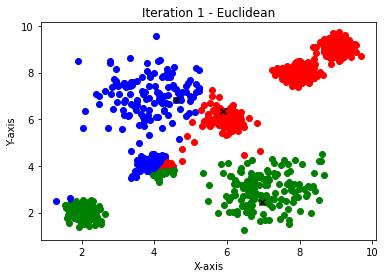

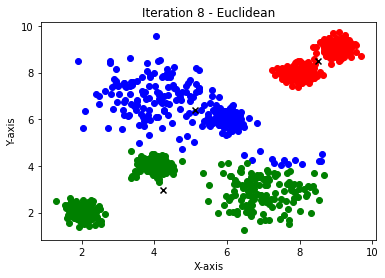

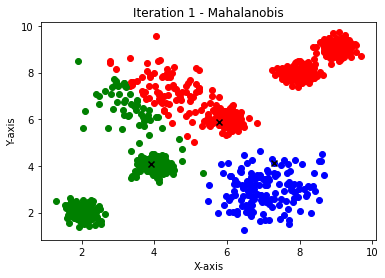

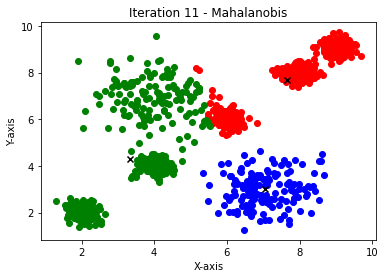

In [12]:
n = 1000 #Number of datapoints
K = 3 #number of clusters
datapoints = readData('part1dataset.txt')

euclidKMeans = clustering(datapoints, K, 100, 0)
mahalKMeans = clustering(datapoints, K, 100, 1)

## Part 1 Discussion

As expected, both versions of the k-means algorithm are able to perform efficiently. It was rather straightforward to implement, but is is clear with certain datasets that I gave it as inputs that the euclidean version tends to outperform visually. In particular, the mahalanobis distance version sometimes fails to recognize obvious clusters that the naked human eye would perceive right away because it is prioritizing groupings that agree with the covariance of the variables. We tend to see cluster boundaries that align with the trend of the data points on the plot.

As for the dataset I designed for it, it is able to partition nicely here because the covariance is non-negligible between x and y values here. It performs more consistently than the euclidean version in this case because the distances are adjusted by taking into account the inverse covariance matrix.

One of the main technical challenges with implementing K-means with mahalanobis distance was to construct the covariance matrix without the use of the numpy function designed for it. It lead me to understand what information is being stored in each element of the covariance matrix and made me appreciate the results that much more. My understanding of the covariance matrix is included in the [Computing covariance matrix](#covMat) section above. I was also necessary to manipulate my data to ensure that matrix multiplication was possible:

$(x-\mu)^{T}\times S^{-1}\times(x-\mu)$  
&nbsp;&nbsp;$(1x2)\times(2x2)\times(2x1)$

### Part 2 of the project...

## Implementing the Davies-Bouldin index


The Davies-Bouldin (DB) index uses a "within-to-between" cluster distance ratio to quantify how optimal a clustering solution is for a given input. The function that we want to minimize is the following:

$DB(C)=\frac{1}{k}\displaystyle\sum_{i=1}^{k}max_{j\leq k\neq i}D_{ij}, k=|C|$,

where $max D_{ij}$ is the "worst case within-to-between cluster ratio" for each cluster. Essentially, we have to compare all cluster to all other clusters in the partition and sum the maximum of those "cluster ratios" for each $C_i$. 

We can define the term "cluster ratio", or $D_{ij}$ as,

$\large D_{ij}=\frac{(\overline d_i+\overline d_j)}{d_{ij}}$,

where $\overline d_i$ and $\overline d_j$ are the average distances between all data points and their centroid in $C_i$ and $C_j$ respectively, and $d_{ij}$ is the Euclidean distance between centroids of $C_i$ and $C_j$.

*Adapted from p.14 of cluster_validation.pdf on UMLearn

## Average distance from centroid

The ``avgFromCentroid(cluster, centroid)`` function takes a list of all data points in a cluster and the centroid in question as parameters and returns the average Euclidean distance of those points to the centroid.

In [13]:
def avgFromCentroid(cluster, centroid):
    totalDist = 0
    for i in range(len(cluster)):
        totalDist += distFromPoint(cluster[i], centroid)
    avgDist = totalDist/len(cluster)
    
    return avgDist

## Davies-Bouldin index calculation

The ``DBIndex(partition, centroids)`` function takes the list of clusters of data points called partition and the list of centroids of a clustering solution as parameters. Both of these are returned by the [clustering() method](#clust) implemented for part 1. It calculates the Davies-Bouldin index of that partition by implementing the function described above.

In [14]:
def DBIndex(partition, centroids):
    dFromCentroids = []
    for i in range(len(partition)):
        dFromCentroids.append(avgFromCentroid(partition[i], centroids[i]))   
    
    worstCaseRatios = []
    currIndex = -1
    for i in range(len(partition)):
        otherIndex = i
        currCluster = partition[i]
        allRatios = []
        doneCompare = False
        while (not doneCompare):
            #Do the comparisons here 
            otherIndex += 1
            if (otherIndex == len(partition)): #ensures that we're not trying to index out of bounds
                otherIndex = 0
            if (otherIndex == i): #once we try to compare Ci with Ci, it's time to end the loop
                doneCompare = True
            else:
                #calculating Dij
                d_i = dFromCentroids[i]
                d_j = dFromCentroids[otherIndex]
                d_ij = distFromPoint(centroids[i], centroids[otherIndex])
                allRatios.append((d_i+d_j)/d_ij)
        #endwhile
        
        worstCaseRatios.append(max(allRatios))
    
    return ((1/len(partition))*sum(worstCaseRatios))


## Part 2 Results

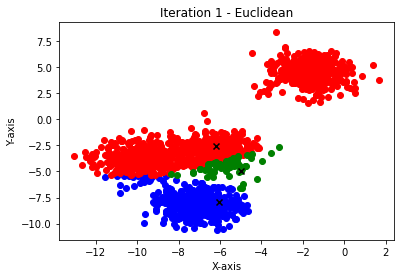

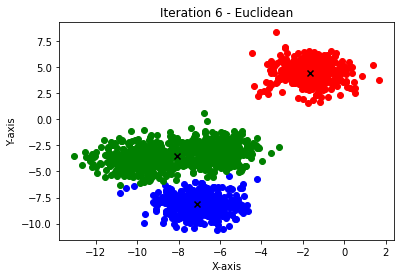

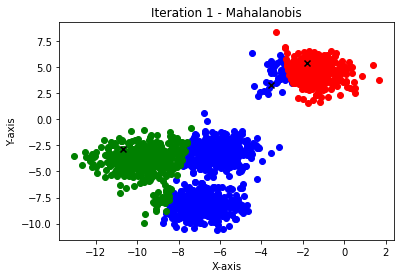

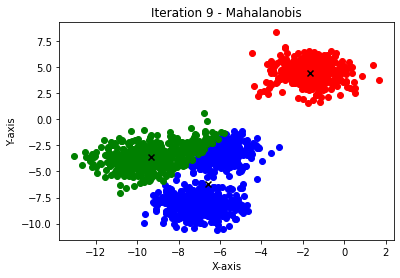

Euclidean clustering has a Davies-Bouldin index of 0.8329698308471776
Mahalanobis clustering has a Davies-Bouldin index of 0.7329399679195188


In [16]:
datapoints = readData('cluster_validation_data.txt')

#Do both clustering versions, looking for 3 clusters, 100 max iterations
euclidKMeans2 = clustering(datapoints, 3, 100, 0)
mahalKMeans2 = clustering(datapoints, 3, 100, 1)

ePartition = euclidKMeans[0]
eCentroids = euclidKMeans[1]

euclidDB = DBIndex(ePartition, eCentroids)

mPartition = mahalKMeans[0]
mCentroids = mahalKMeans[1]

mahalDB = DBIndex(mPartition, mCentroids)

print("Euclidean clustering has a Davies-Bouldin index of " + str(euclidDB))
print("Mahalanobis clustering has a Davies-Bouldin index of " + str(mahalDB))


## Part 2 Discussion

With the human eye, you could argue that this dataset consists of three or four clusters. I tried both and found that the results with K=3 were more interesting to discuss. There is clearly a difference in the way that the two version of the algorithms approximated their partitions. The euclidean version usually settles on having the large wide cluster be completely separate from the smaller cluster below it. This agrees nicely with what a human would settle on if they were told to find three clusters in this scatter plot. On the other hand, the mahalanobis version is insistent on including the right-side of the wide cluster as part of the bottom cluster. This is because the covariance matrix indicates a trend from the botom left to the top right. Mahalanobis distance calculations therefore give an edge to distance calculations that form a cluster in that diagonal direction. This is not the ideal solution. 

In all of the executions of my algorithms I have done for this dataset, the euclidean distance version always edges out the mahalanobis distance with a lower DB index, which quantifies it as more optimal. It is also worth mentionning that the euclidean version also consistently settles on a partition in fewer iterations, which is another positive when it comes to this dataset.